<a href="https://colab.research.google.com/github/muhammedkoussa/BrainTumorDetection/blob/main/Proje_Son_Hali_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uyarı mesajlarını görmezden gelmek için

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
'''
import shutil

shutil.rmtree('dosya yolu', ignore_errors=True)
'''
#klasörleri silmek için kod

"\nimport shutil\n\nshutil.rmtree('dosya yolu', ignore_errors=True)\n"

# Kaggle Python kütüphanesini yükledik.





In [3]:
!pip install kaggle



*Kaggle API kullanabilmek için google drive tanımladık.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!mkdir ~/.kaggle

Kaggle'den indirip drive yükledğimiz JSON doyasını kopyaladık.


In [6]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download ahmedhamada0/brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection
License(s): copyright-authors
 77% 65.0M/84.0M [00:00<00:00, 165MB/s]
100% 84.0M/84.0M [00:00<00:00, 158MB/s]


In [9]:
!unzip brain-tumor-detection

Archive:  brain-tumor-detection.zip
  inflating: Br35H-Mask-RCNN/TEST/annotations_test.json  
  inflating: Br35H-Mask-RCNN/TEST/y701.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y702.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y703.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y704.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y705.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y706.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y707.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y708.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y709.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y710.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y711.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y712.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y713.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y714.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y715.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y716.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y717.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y718.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y719.jpg  
  inflating: Br35H-Mask-RCNN/TEST/y720.jpg  
  infl

Gerekli olan kütüphanelerin import edilmesi

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

* NumPy çok boyutlu dizileri, matrisleri ve üst düzey matematiksel işlevler ekleyen bir kitaplıktır
* MatPlotLib  görselleştirme kütüphanesidir.
* Os modülü Python'da hazır olarak gelen , dosya ve dizinlerde kolaylıkla işlemler yapmamızı sağlayan bir modüldür.
* math modülü matematiksel işlemler yapmanızı kolaylaştırmak için yazılmış bir modüldür.
* Shutil dizinler üzerinde bulunan dosyaları kopyalama , taşıma , açma, okuma , yazma ve kapatma gibi işlemleri “OS” modülü ile beraber basitçe yapmamızı sağlayan bir Python modülüdür.
* Glob modülü, Python'da belirli bir klasör içindeki dosyaları listelememize yardımcı olan harika bir modüldür. Bu modülü kullanırken filtreleme yaparak, sadece istenilen dosyaların listelenmesini de sağlayabiliyoruz.

In [11]:
import os

# Colab'da boş bir klasör oluşturun
os.mkdir("DataSet")


# Klasörü Colab'daki "dosyalar" dizinine taşıyın
os.rename("yes", "DataSet/yes")
os.rename("no", "DataSet/no")


DataSette kaç adet resim bulunduğunu tespit eden kod

In [12]:
ROOT_DIR = "/content/DataSet"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir]=len(os.listdir(os.path.join(ROOT_DIR,dir)))

number_of_images.items()

dict_items([('yes', 1500), ('no', 1500)])

#veriyi şöyle ayırdık
* Train için %70
* Validation %15
* Test %15

Bu kod, verilen ROOT_DIR dizininin altındaki tüm dizinlerden rastgele seçilmiş resimleri belirtilen split oranına göre ikiye ayırır ve ayırdığı resimleri iki ayrı klasöre kopyalar.

In [13]:
def dataFolder(p, split):

#Train için klasör oluşturduk
  if not os.path.exists("./"+p):
    os.mkdir("./"+p)

    for dir in os.listdir(ROOT_DIR):
       os.makedirs("./"+p+"/"+dir)

       for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR,dir)) ,
                                size=(math.floor(split*number_of_images[dir])-5),
                                replace=False ):
         O = os.path.join(ROOT_DIR,dir,img) #path
         D = os.path.join("./"+p,dir)
         shutil.copy(O,D)
         os.remove(O)

  else:
    print(f"{p} Bu Dosya Mevcuttur")

In [14]:
dataFolder("train" , 0.7)

In [15]:
dataFolder("val" , 0.15)

In [16]:
dataFolder("test" , 0.15)

***MODEL OLUŞTURMA ***

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


In [19]:
"""
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras
"""



ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (/usr/local/lib/python3.10/dist-packages/keras/api/preprocessing/image/__init__.py)

CNN MODEL

eğitilmemiş boş model oluşturduk

In [22]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential

# Modelin tanımı
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(filters=36, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))

model.add(Dropout(rate=0.25))
model.add(Dense(units=1, activation='sigmoid'))

# Modelin özeti
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 220, 220, 36)        │           5,220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 36)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 108, 108, 64)        │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       5,537,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,638,245 (21.51 MB)

 Trainable params: 5,638,245 (21.51 MB)

 Non-trainable params: 0 (0.00 B)

modeli eğitmek için kullanacagımız algoritmayı seçtik

data generator kullanarak verilerimizi hazırlıyoruz

verinin dataseti hazırlanılyor

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input


dosya yolundan verilerin veriseti olarak hazırlanması ve gereken boyutlama işleme yaplıyor.

In [25]:
def preprocessingImages1(path):
  """"
input : Path
output Pre processed images
"""
  image_data = ImageDataGenerator(zoom_range= 0.2, shear_range= 0.2, preprocessing_function=preprocess_input, horizontal_flip= True)
  image = image_data.flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode = 'binary')

  return image

In [26]:
path = "/content/train"
train_data = preprocessingImages1(path)

Found 2090 images belonging to 2 classes.


In [27]:
train_data.class_indices

{'no': 0, 'yes': 1}

test verisini orjinalliğine koruyarak dataset oluşturuyor.

In [28]:
def preprocessingImages2(path):
  """"
input : Path
output Pre processed images
"""
  image_data = ImageDataGenerator(preprocessing_function=preprocess_input )
  image = image_data.flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode = 'binary')

  return image

In [29]:
path = "/content/test"
test_data = preprocessingImages2(path)

Found 440 images belonging to 2 classes.


In [30]:
path = "/content/val"
val_data = preprocessingImages2(path)

Found 440 images belonging to 2 classes.


Model Eğitimi

In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.applications.mobilenet import MobileNet
import keras

Hızlı ve Güç tüketimi düşük bu tarz verilerde en yüksek doğruluk oranı veren MobileNet

In [32]:
base_model = MobileNet(input_shape=(224,224,3), include_top= False)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [33]:
for layer in base_model.layers:
   layer.trainable = False

In [34]:
X = Flatten()(base_model.output)
X = Dense(units=1 ,activation='sigmoid')(X)
model = Model(base_model.input, X)

In [35]:
model. summary()


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,279,041 (12.51 MB)

 Trainable params: 50,177 (196.00 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [36]:
model.compile(optimizer='rmsprop', loss= keras.losses.binary_crossentropy , metrics=['accuracy'])

In [ ]:
"""
#Call Back
from keras.callbacks import ModelCheckpoint, EarlyStopping
# model Check point
mc=ModelCheckpoint(filepath="bestmodel.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
#Early Stopping 5 kere improve olmazsa model.fit duraklar
es = EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=5, verbose=1)
cb = [mc,es]

"""


In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks: ModelCheckpoint ve EarlyStopping
cb = [
    ModelCheckpoint(
        filepath="bestmodel.keras",  # ".keras" uzantısı ile güncellendi
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True
    ),
    EarlyStopping(
        monitor="val_accuracy",
        min_delta=0.01,
        patience=5,
        verbose=1
    )
]


In [44]:
hist = model.fit(
    train_data,
    steps_per_epoch=6,
    epochs=50,
    verbose=1,
    validation_data=val_data,
    validation_steps=10,
    callbacks=cb
)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4681 - loss: 10.7137
Epoch 1: val_accuracy improved from -inf to 0.85938, saving model to bestmodel.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.4794 - loss: 10.6368 - val_accuracy: 0.8594 - val_loss: 0.8359
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8176 - loss: 1.6078
Epoch 2: val_accuracy did not improve from 0.85938
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8065 - loss: 1.7406 - val_accuracy: 0.7667 - val_loss: 2.0947
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7783 - loss: 1.6704
Epoch 3: val_accuracy improved from 0.85938 to 0.86250, saving model to bestmodel.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - accuracy: 0.7881 - loss: 1.5783 - val_accuracy: 0.8625 - val_loss: 0.9125
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8990 - loss: 0.4576
Epoch 4: val_accuracy improved from 0.86250 to 0.92500, saving model to bestmodel.keras
6/6 ━━━━━━━━━━━━━━━━━━━

In [46]:
# En iyi modeli yükleme
model = load_model("/content/bestmodel.keras")


In [48]:
# Modeli test verisiyle değerlendirme
acc = model.evaluate(test_data)
print(f"Our model accuracy is {acc[1] * 100} %")


14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9619 - loss: 0.3003
Our model accuracy is 96.13636136054993 %


# Yeni Bölüm

In [49]:
h = hist.history
h.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

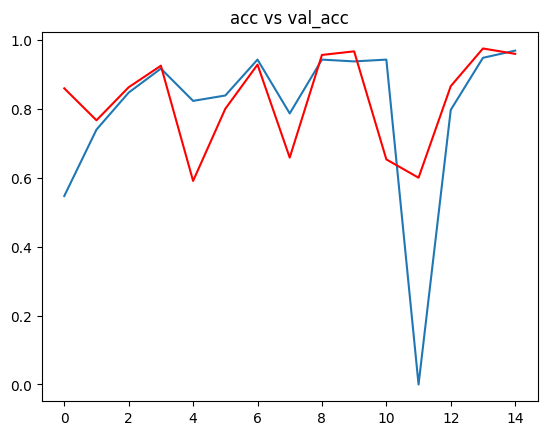

In [50]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c='red')
plt.title("acc vs val_acc")
plt.show()

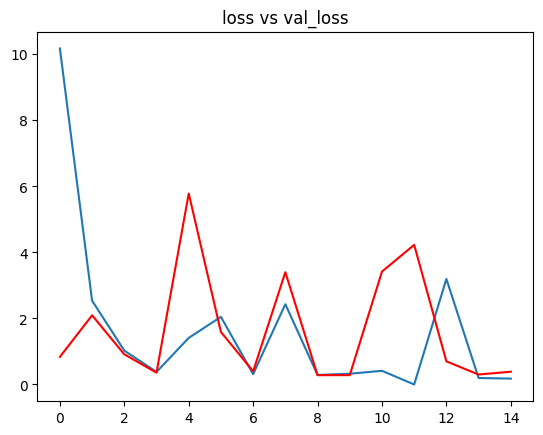

In [51]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c='red')
plt.title("loss vs val_loss")
plt.show()

In [52]:
from keras.preprocessing import image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[[6.638688e-07]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
[[0.]]
Bu MR Görüntüsünde Tümör Tespit Edilmemiştir.


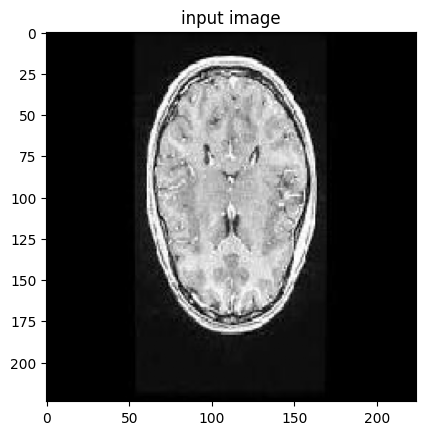

In [55]:
# path for the image to see if it predics correct class
path = "/content/test/no/no1000.jpg"

img = tf.keras.utils.load_img(path, target_size=(224,224) )

i = tf.keras.utils.img_to_array(img)/255
input_arr = np.array([i])

input_arr.shape
pred = np.round_(model.predict(input_arr))

print(model.predict(input_arr))
print(np.round_(model.predict(input_arr)))

if pred == 0:
  print("Bu MR Görüntüsünde Tümör Tespit Edilmemiştir.")

else :
  print("Bu MR Görüntüsünde Tümör Tespit Edilmiştir.")

# to display the image
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()